# Classification using Random Forest

In this chapter we will be using the Random Forest implementation provided by the `scikit-learn` library. Scikit-learn is an amazing machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including NumPy, SciPy, and matplotlib, which makes it very easy to incorporate into your workflow. The number of available methods for accomplishing any task contained within the library is (in my opinion) its real strength. No single algorithm is best for all tasks under all circumstances, and scikit-learn helps you understand this by abstracting the details of each algorithm to simple consistent interfaces.

This following figure shows the classification predictions and the decision surfaces produced for three classification problems using 9 different classifiers.

<img src="https://scikit-learn.org/0.15/_images/plot_classifier_comparison_0011.png">

credit : https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

In [38]:
import glob, os, time
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import features

import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from pathlib import Path
from IPython.display import display

print(f'Numpy : {np.__version__}')
print(f'Pandas : {pd.__version__}')
print(f'GeoPandas : {gpd.__version__}')
print(f'Scikit-learn: {sklearn.__version__}')

Numpy : 1.19.2
Pandas : 1.1.5
GeoPandas : 0.8.1
Scikit-learn: 0.24.1


## Set paths for input and output directories

In [2]:
#computer_path = 'X:/'
computer_path = '/Volumes/nbdid-sst-lbrat2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'

# ----- #
# INPUT #
# ----- #

im_path   = f'{work_path}3_L2A_MASKED/'
ndvi_path = f'{work_path}NDVI/'

in_situ_SD_path = f'{work_path}IN_SITU_SD/'

# ------ #
# OUTPUT #
# ------ #

classif_path = f'{work_path}CLASSIF/'

Path(classif_path).mkdir(parents=True, exist_ok=True)

print(f'Classification path are set to : {classif_path}')


Classification path are set to : /Volumes/nbdid-sst-lbrat2104/GROUP_X/WORK/CLASSIF/


## Preparing the dataset

### Rasterize in-situ data shapefile


In [4]:
# Set up filenames

in_situ_name = 'WALLONIA_2018_IN_SITU_ROI'

in_situ_cal_shp = f'{in_situ_SD_path}{in_situ_name}_cal.shp'
in_situ_cal_tif = f'{in_situ_SD_path}{in_situ_name}_cal.tif'
in_situ_val_shp = f'{in_situ_SD_path}{in_situ_name}_val.shp'
in_situ_val_tif = f'{in_situ_SD_path}{in_situ_name}_val.tif'

#img_temp_tif = glob.glob(f'{work_path}2_L2A_CLIPPED/*.tif')[0]
img_temp_tif = glob.glob(f'{im_path}*.tif')[0]

print(f'Raster template file : {img_temp_tif}')


for shp, raster in zip([in_situ_cal_shp, in_situ_val_shp],[in_situ_cal_tif, in_situ_val_tif]):
    
    print(f'Rasterize {shp}')

    # Open the shapefile with GeoPandas

    in_situ_gdf = gpd.read_file(shp)

    # Open the raster file you want to use as a template for rasterize

    src = rasterio.open(img_temp_tif, "r")

    # Update metadata
    profile = src.profile
    profile.update(nodata=0)

    # Burn the features into the raster and write it out

    dst = rasterio.open(raster, 'w+', **profile)
    dst_arr = dst.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing

    geom_col = in_situ_gdf.geometry
    code_col = in_situ_gdf.CODE.astype(int)

    shapes = ((geom,value) for geom, value in zip(geom_col, code_col))

    in_situ_arr = features.rasterize(shapes=shapes,
                                        fill=0,
                                        out=dst_arr,
                                        transform=dst.transform)

    dst.write_band(1, in_situ_arr)

    # Close rasterio objects
    src.close()
    dst.close()


Raster template file : /Volumes/nbdid-sst-lbrat2104/GROUP_X/WORK/3_L2A_MASKED/T31UFS_20200116T105309_B02_10m_ROI_SCL.tif
Rasterize /Volumes/nbdid-sst-lbrat2104/GROUP_X/WORK/IN_SITU_SD/WALLONIA_2018_IN_SITU_ROI_cal.shp
Rasterize /Volumes/nbdid-sst-lbrat2104/GROUP_X/WORK/IN_SITU_SD/WALLONIA_2018_IN_SITU_ROI_val.shp


## List all the classification features

In this case, one NDVI per month

In [9]:
# Get list of all files containing the features
list_im = sorted(glob.glob(f'{ndvi_path}*.tif'))

# Create an empty list to append all feature rasters one by one
list_src_arr = []

for im_file in list_im:

    src = rasterio.open(im_file, "r")
    im = src.read(1)
    list_src_arr.append(im)
    src.close()

# Merge all the 2D matrices from the list into one 3D matrix

feat_arr = np.dstack(list_src_arr).astype(np.float32)

print(feat_arr.shape)
print(f'There are {feat_arr.shape[2]} features')
print(f'The features type is : {feat_arr.dtype}')

#feat_arr_1 = np.stack(list_src_arr, axis=0)
#print(feat_arr_1.shape)

(570, 986, 12)
There are 12 features
The features type is : float32


### Pairing Y with X

Now that we have the image we want to classify (our X feature inputs), and the ROI with the land cover labels (our Y labeled data), we need to pair them up in NumPy arrays so we may feed them to Random Forest.

In [13]:
# Open in-situ used for calibration

src = rasterio.open(in_situ_cal_tif, "r")
cal_arr = src.read(1)
src.close()

# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (cal_arr > 0).sum()

print(f'We have {n_samples} samples\n')


# What are our classification labels?
labels = np.unique(cal_arr[cal_arr > 0])
print(f'The training data include {labels.size} classes: {labels} \n')


# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = feat_arr[cal_arr > 0, :]
y = cal_arr[cal_arr > 0]

# Replace NaN by another value
X = np.nan_to_num(X, nan=-10)

print(f'Our X matrix is sized: {X.shape}')
print(f'Our y array is sized: {y.shape}')


We have 39200 samples

The training data include 25 classes: [   6    9   12   19   20   21   36   45   62   73   91  201  311  321
  342  541  542  821  901  931 4111 9410 9741 9742 9812] 

Our X matrix is sized: (39200, 12)
Our y array is sized: (39200,)


## Training the Random Forest

Now that we have our X matrix of feature inputs and our y array, we can train our model.

Visit this <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html" target="_blank">web page</a>  to find the usage of RandomForestClassifier from scikit-learn.

In [14]:
start_training = time.time()

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

end_training = time.time()

# Get time elapsed during the Random Forest training
hours, rem = divmod(end_training-start_training, 3600)
minutes, seconds = divmod(rem, 60)
print("Random Forest training : {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Random Forest training : 00:01:19.89


With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [15]:
print(f'Our OOB prediction of accuracy is: {round(rf.oob_score_ * 100,2)}%')


Our OOB prediction of accuracy is: 99.1%


To help us get an idea of which features bands were important, we can look at the feature importance scores:

In [16]:
for band_nb, imp in enumerate(rf.feature_importances_, start=1):
    print(f'Band {band_nb} importance: {round(imp,4)}')

Band 1 importance: 0.0745
Band 2 importance: 0.0338
Band 3 importance: 0.0822
Band 4 importance: 0.0953
Band 5 importance: 0.0835
Band 6 importance: 0.0754
Band 7 importance: 0.0909
Band 8 importance: 0.0942
Band 9 importance: 0.1058
Band 10 importance: 0.0937
Band 11 importance: 0.0909
Band 12 importance: 0.0797


Let's look at a crosstabulation to see the class confusion

In [22]:
# Setup a dataframe
df = pd.DataFrame()

df['truth'] = y
df['predict'] = rf.predict(X)

print(y)
print(rf.predict(X))

# Cross-tabulate predictions

#cross_tab = pd.crosstab(df['truth'], df['predict'], margins=True)

#display(cross_tab)


[91 91 91 ... 21 21 21]
[91 91 91 ... 21 21 21]


## Predicting the rest of the image

With our Random Forest classifier fit, we can now proceed by trying to classify the entire image.

In [18]:
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification

img = feat_arr

img = np.nan_to_num(img, nan=-10)

new_shape = (img.shape[0] * img.shape[1], img.shape[2])

img_as_array = img[:, :, :].reshape(new_shape)

print(f'Reshaped from {img.shape} to {img_as_array.shape}')


start_classification = time.time()

# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

end_classification = time.time()

hours, rem = divmod(end_classification-start_classification, 3600)
minutes, seconds = divmod(rem, 60)
print("Random Forest training : {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))



Reshaped from (570, 986, 12) to (562020, 12)
Random Forest training : 00:01:23.27


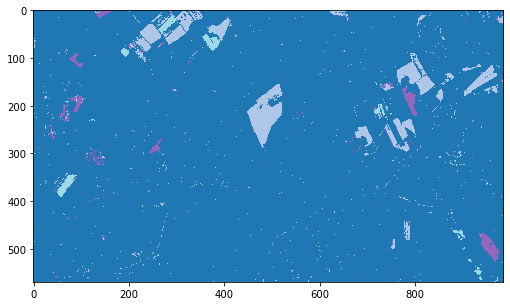

In [21]:
classif_tif = f'{classif_path}Classif_RF_with_NDVI.tif'

print(f'Size of image : {class_prediction.shape}')

# Open template image to get metadata
src = rasterio.open(img_temp_tif)
im = src.read(1)
profile = src.profile

# Write classification image
dst = rasterio.open(classif_tif, 'w', **profile)
dst.write(class_prediction, 1)

# Close rasterio objects
src.close()
dst.close()

Size of image : (570, 986)


## Validation

In [74]:
cm_csv = f'{classif_path}Classif_RF_with_NDVI_CM.csv'

# Open in-situ used for calibration

src = rasterio.open(in_situ_val_tif, "r")
val_arr = src.read(1)
src.close()

# Get the postion of validation pixels
idx = np.where(val_arr > 0, 1, val_arr).astype(bool)

# Get the truth vector and the prediction vector
truth_val   = val_arr[idx]
predict_val = class_prediction[idx]

# Compute Confusion Matrix
cm = confusion_matrix(truth_val, predict_val)

# Convert CM into panda dataframe and save it
cm_df = pd.DataFrame(cm)
display(cm_df)
cm_df.to_csv(cm_csv, index=False, sep=';')

cm_values = cm_df.values

# Compute Overall accuracy

OA = (np.trace(cm) / float(np.sum(cm))) *100

print(f'Overall Accuracy : {round(OA,2)}%')



#oa = (np.trace(cm_values) / float(np.sum(cm_values))) *100
#print(f'Overall Accuracy : {round(oa,2)}%')


#pd.DataFrame(cm).to_csv(cm_csv, index=False, sep=';')
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#plot_confusion_matrix(rf, class_prediction, val_arr)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,795,0,0,5,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,144,1,0,0,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
2,10,0,0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,555,0,30,0,0,0,2,...,2,0,0,0,0,0,0,0,0,0
4,11,0,0,18,2,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,2,0,54,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,9,0,0,21,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,6,0,0,3,...,0,0,0,1,0,0,0,0,0,0
8,0,0,0,18,0,0,122,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,101,0,0,69,1,0,94,0,0,9562,...,139,1,0,90,0,0,0,0,6,0


Overall Accuracy : 41.23%
